In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from csv import reader
# import seaborn as sb
import skimage
from skimage import io, transform, exposure, data, color
from skimage.color import *
import sys
import PIL
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

BBBC038 = "/raid/data/BBBC038/"
training_imgs_dir = "/raid/data/BBBC038/training/"
# os.chdir(BBBC038)

In [2]:
def extract_features(im):
    im = skimage.exposure.rescale_intensity(im)
    color_hist = []
    for c in range(3):
        if len(im.shape) == 3:
            color_hist.append( np.histogram(im[:,:,c], 255)[0] ) # computes histogram of 255 pixel values (0 is black)
        else:
            color_hist.append( np.histogram(im[:,:], 255)[0] )
    feat = np.concatenate(color_hist)
    feat = feat / (im.shape[0] * im.shape[1] * 3 )
    return np.expand_dims(feat, axis=0)

In [3]:
def getImage(path,zoom=0.08): # redistributes intensity of an image so bright pixels are more prominent
    im = skimage.io.imread(path)
    im = skimage.exposure.equalize_adapthist(im)
    return OffsetImage(im,zoom=zoom)

# View sample image

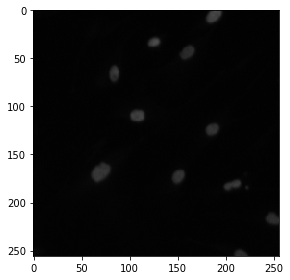

In [4]:
sample_dir = "/raid/data/BBBC038/training/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0/"
os.listdir(sample_dir + 'images/')
io.imshow(sample_dir + 'images/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0.png')

# Load Data

In [5]:
im_paths = []
mk_paths = []

for im_path in os.listdir(training_imgs_dir):
    path_masks = f"{training_imgs_dir}/{im_path}/masks/{im_path}"
    path_image = f"{training_imgs_dir}/{im_path}/images/{im_path}.png"

    mk_paths.append(path_masks)
    im_paths.append(path_image)

# sample
# io.imshow(im_paths[255])


# Load Labeled Data

In [31]:
image_groups = pd.read_csv(BBBC038 + "training_classifications.csv")
full_name = []

# unsure what to pull from csv
for i, image_name in image_groups.iterrows():
    full_name.append(image_name)
    
image_groups[image_groups["Type"] == "Purple"]
# full_name[2][1]
# image_groups["Type"].unique()

,Type,Image_Name
566,Purple,0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a389...
567,Purple,7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f4...
568,Purple,ed5be4b63e9506ad64660dd92a098ffcc0325195298c13...
569,Purple,33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4e...
570,Purple,40946065f7e4b6038599fbfd419f2a67e7635b6f89db3e...
...,...,...
665,Purple,a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9...
666,Purple,815524d88283ba10ad597b87aa1967671db776df8004a0...
667,Purple,3b0709483b1e86449cc355bb797e841117ba178c6ae1ed...
668,Purple,1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20...


# Find all Purple images
* get path for all purple images in directory

In [7]:
csv_lines = []
purple_png_list = []
with open(BBBC038 + "training_classifications.csv") as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        csv_lines.append(row)
for row in csv_lines:
    if "Purple" in row:
        purple_png_list.append(row[1])

# len(purple_png_list) # 104, as expected

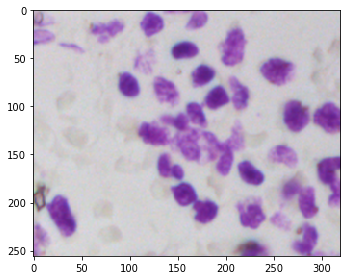

In [8]:
io.imshow(training_imgs_dir + purple_png_list[2][:-4] + "/images/" + purple_png_list[2])


# Load Masks

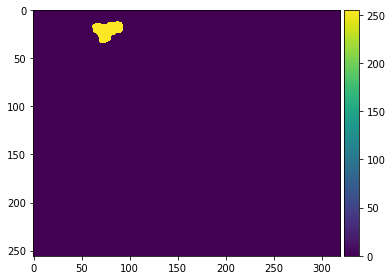

In [40]:
purp_collections = []
for i in range(104):
    curr_img_path = training_imgs_dir + purple_png_list[i][:-4] + "/masks/*.png"
    imcoll = io.collection.ImageCollection(curr_img_path)
    purp_collections.append(imcoll)
    
# first index is image collection, second is mask within collection
io.imshow(purp_collections[2][0])

# Unmix Colors from Purple Images
* use separate stains (possibility)
    * did not work, separate stain couldn't reshape image

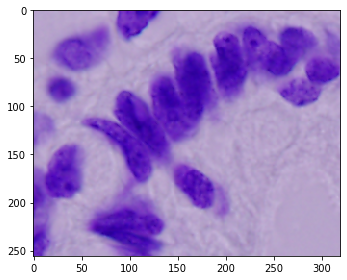

In [43]:
purp_sample_png_path = training_imgs_dir + purple_png_list[3][:-4] + "/images/" + purple_png_list[3]
purp_img = io.imread(purp_sample_png_path)
io.imshow(purp_img)

# Identify most prominent color (may remove later, ML better suited for this task)
* open an image, turn it into an array
* find clusters
* count color occurrences
* find most frequent color

In [ ]:
from __future__ import print_function
import binascii
import struct
from PIL import Image, ImageOps
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

def id_color(image):
    print('reading image')
    im = Image.open('/Users/ebueno/Desktop/Python Stuff/skimage-tutorials/images/fingers.png')
    im = im.resize((150, 150))      # optional, to reduce time
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding clusters')
    NUM_CLUSTERS = 5
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('cluster centres:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences

    index_max = np.argmax(counts)                    # find most frequent
    peak = codes[index_max]
    colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
    print('most frequent is %s (#%s)' % (peak, colour))
    return colour